## Collecting stories through MediaCloud

The following markdown goes over steps to retrieve stoes from the MediaCloud platform.

In [56]:
from dotenv import load_dotenv
import os, mediacloud.api
import datetime
import json
import pandas as pd 
from IPython.display import JSON
import mediacloud.tags
import csv
import requests
import time
import newsplease
from tqdm import tqdm
from newsplease import NewsPlease
from urllib.parse import urlparse

### Setting up

First we instantiate a client with the private API key. 

In [4]:
mc = mediacloud.api.MediaCloud('439141f9647ae800fa099bf77e4297ea28fe3f2bbc2d64b1f2163ad52fd8fef2')
mediacloud.__version__

'3.12.5'

In [3]:
# make sure your connection and API key work by asking for the high-level system statistics
mc.stats()

{'active_crawled_feeds': 163686,
 'active_crawled_media': 58419,
 'daily_downloads': 1127868,
 'daily_stories': 638707,
 'mediacloud_stats_id': 11,
 'stats_date': '2022-04-10',
 'total_downloads': 0,
 'total_sentences': 0,
 'total_stories': 0}

### Sources and Collections

In [67]:
matching_sources = mc.mediaList(name_like='nbc news', sort='num_stories')
JSON(matching_sources)
[m['media_id'] for m in matching_sources]

[25499]

### Stories per outlet (wlmwng code)

In [ ]:
def get_outlet_story_count(mc, media_id, start_time, end_time):
     """
     Args:
         - mc (obj): a `mediacloud.api.MediaCloud` object already instantiated with the API key
         - media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])
         - start_time (datetime)
         - end_time (datetime)

     Returns:
         - story_count (int)
     """
     date_range = mc.dates_as_query_clause(start_time, end_time-datetime.timedelta(days=1)) # default is start & end inclusive
     story_count = mc.storyCount(f'media_id:{media_id}', date_range)['count']
     return story_count


get_outlet_story_count(mc, '1092', start_date, end_date)

### Measuring Attention

We are ready to query Media Cloud for data. First we measure attention paid to an issue by the media. Two methods are particularly helpful for studying attention: storyCount and storyList. We start by looking at attention from a single media source.

#### storyCount

We collect stories from Washington Post, Washington Times, Fox News, Breitbart, CNN, NBC News and New York Post

In [10]:
# check how many stories mention voter ID in Fox News
my_query = '("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:1092 OR media_id:2 OR media_id:101 OR media_id:1095 OR media_id:19334 OR media_id:7 OR media_id:25499)'
mc.storyCount(my_query)

{'count': 4952}

In [50]:
# limit this to stories from 2013-2022
start_date = datetime.date(2013,1,1)
end_date = datetime.date(2022,3,30)
date_range = mc.dates_as_query_clause(start_date, end_date) # default is start & end inclusive
mc.storyCount(my_query, date_range)

{'count': 4391}

In [47]:
# you can see this over time by using the `split` argument
# this defaults to results by day, but you can pass a split_period in (day, week, month, or year)
results = mc.storyCount(my_query, date_range, split=True, split_period='year')
JSON(results)


<IPython.core.display.JSON object>

In [48]:
import pandas as pd

df = pd.DataFrame(results['counts'])
print(df)


   count                 date
0    235  2013-01-01 00:00:00
1    356  2014-01-01 00:00:00
2    186  2015-01-01 00:00:00
3    589  2016-01-01 00:00:00
4    490  2017-01-01 00:00:00
5    513  2018-01-01 00:00:00
6    253  2019-01-01 00:00:00
7    579  2020-01-01 00:00:00
8   1077  2021-01-01 00:00:00
9     68  2022-01-01 00:00:00


<AxesSubplot:xlabel='date'>

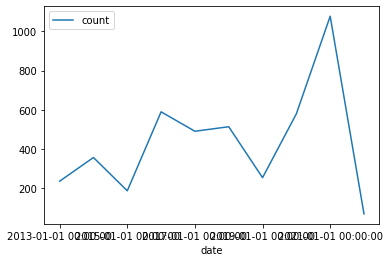

In [49]:
df.plot(x='date', y='count', fontsize=10)

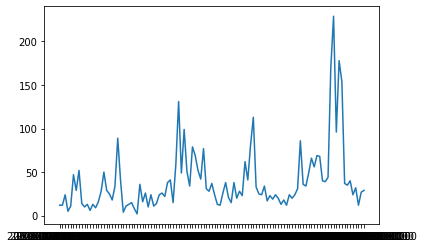

In [31]:
import matplotlib.pyplot as plt
plt.plot(df["date"], df["count"])

In [ ]:
# we compare attention to the total number of stories we have from a source within that same timespan.
relevant_stories = mc.storyCount(my_query, date_range)
total_stories = mc.storyCount('media_id:1092', date_range)
source_ratio = relevant_stories['count'] / total_stories['count']
'{:.2%} of Fox News stories are about "voter ID"'.format(source_ratio)

#### storyList

Here we get a list of all the URLs. We can also return word counts down to the story level.

In [32]:
# grab a random set of stories about this issue (defaults to 20 stories)
# note that this seed is fixed, so it will return the same set of random stories each call you make
stories = mc.storyList(my_query, date_range, sort=mc.SORT_RANDOM)
JSON(stories)

<IPython.core.display.JSON object>

In [33]:
# If we want to list ALL the stories matching, we need to page through the results. 
# This is accomplished via the last_processed_stories_id parameter. This code snippet pages through all the stories in a query.
def all_matching_stories(mc_client, q, fq):
    """
    Return all the stories matching a query within Media Cloud. Page through the results automatically.
    :param mc_client: a `mediacloud.api.MediaCloud` object instantiated with your API key already
    :param q: your boolean query
    :param fq: your date range query
    :return: a list of media cloud story items
    """
    last_id = 0
    more_stories = True
    stories = []
    while more_stories:
        page = mc_client.storyList(q, fq, last_processed_stories_id=last_id, rows=500, sort='processed_stories_id')
        print("  got one page with {} stories".format(len(page)))
        if len(page) == 0:
            more_stories = False
        else:
            stories += page
            last_id = page[-1]['processed_stories_id']
    return stories

In [34]:
# let's fetch all the stories matching our query (this can take a few minutes)
year2020 = mc.dates_as_query_clause(datetime.date(2013,1,1), datetime.date(2022,3,30))
all_stories = all_matching_stories(mc, my_query, year2020)
len(all_stories)

  got one page with 290 stories
  got one page with 220 stories
  got one page with 105 stories
  got one page with 128 stories
  got one page with 285 stories
  got one page with 266 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 325 stories
  got one page with 0 stories


2619

Writing a CSV of Story Data

In [37]:
# first flatten things a little bit to make writing a CSV easier
for s in all_stories:
    # see the "language" notebook for more details on themes
    theme_tag_names = ','.join([t['tag'] for t in s['story_tags'] if t['tag_sets_id'] == mediacloud.tags.TAG_SET_NYT_THEMES])
    s['themes'] = theme_tag_names
# now write the CSV
fieldnames = ['stories_id', 'publish_date', 'title', 'url', 'language', 'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url']
with open('story-list.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction='ignore')
    writer.writeheader()
    for s in all_stories:
        writer.writerow(s)

In [ ]:
import pandas
corpus = pandas.read_csv('story-list.csv', encoding='cp1252')
len(corpus)
corpus.head()

In [43]:
pd.DataFrame(corpus['media_name'].value_counts()) #counting urls per news media source

,media_name
Washington Post,601
Washington Times,543
Fox News,506
Breitbart,373
CNN,324
NBC News,170
New York Post,102


In [55]:
# create list of urls from pandas dataframe
urls = corpus['url'].to_list()
len(urls)

2619

In [ ]:
# retrieve html pages from list of urls 
allpages = {}
for url in tqdm(urls):
    try:
        r = requests.get(url)
        if r.status_code==200:
            allpages[url] = r.text #only read the html text if page exists
        else:
            print(f'Downloading {url} returned status code {r.status_code}')
    except:
        print(f'some error occurred when downloading {url}')
with open('TMP.json',  mode='w') as f:
    json.dump( allpages, f)

In [58]:
len(allpages) # check how many pages were retrieved


2453

In [59]:
allpages_parsed = {}
for k, v in tqdm(allpages.items()):
    allpages_parsed[k] = NewsPlease.from_html(v) # use NewsPlease here to download the stories from the html info retrieved

100%|██████████| 2453/2453 [37:55<00:00,  1.08it/s] 


In [61]:
with open("output.json", mode = 'w') as f: #write json file with media data
    for k, v in allpages_parsed.items():
        mydict = v.get_serializable_dict()
        mydict['url'] = k
        f.write(json.dumps(mydict))
        f.write("\n")

In [63]:
data = pd.read_json('output.json', lines=True) # convert to dataframe
data.head()

,authors,date_download,date_modify,date_publish,description,filename,image_url,language,localpath,maintext,source_domain,text,title,title_page,title_rss,url
0,"[The Washington Times Https, The Associated Pr...",None,None,2015-05-12 14:02:41,"Tribune-Star, Terre Haute. May 11, 2015.",.json,//twt-assets.washtimes.com/images/favicon.3033...,en,NaN,"Tribune-Star, Terre Haute. May 11, 2015.\nSlim...",NaN,NaN,Recent editorials published in Indiana newspapers,NaN,NaN,http://feedproxy.google.com/~r/Sports-TheWashi...
1,"[Tampa Tim, Rudy Nyc, The, Compassionate, Gop ...",None,None,2014-04-30 00:00:00,(CNN) -- In an exclusive interview with CNN Ch...,.json,http://i2.cdn.turner.com/cnn/dam/assets/140430...,en,NaN,8 years ago\n(CNN) - In an exclusive interview...,NaN,NaN,Rep. Thompson doubles down on racial remarks i...,NaN,NaN,http://politicalticker.blogs.cnn.com/2014/04/3...
2,[],None,None,2014-06-04 12:35:55,A look at the likely limited spread of Seattle...,.json,https://www.washingtonpost.com/resizer/2CjPNwq...,en,NaN,Wonkbook’s Chart of the Day: The decreasing va...,NaN,NaN,Wonkbook: Will Seattle’s $15 minimum wage expe...,NaN,NaN,http://www.washingtonpost.com/blogs/wonkblog/w...
3,"[The Washington Times Https, Gary D. Robertson]",None,None,2014-02-08 18:45:20,Following a year marked by hundreds of arrests...,.json,https://twt-thumbs.washtimes.com/media/image/2...,en,NaN,"RALEIGH, N.C. (AP) - Following a year marked b...",NaN,NaN,"Multitude at ""Moral March"" protest NC GOP poli...",NaN,NaN,http://www.washingtontimes.com/news/2014/feb/8...
4,[],None,None,2013-07-05 12:59:09,Arguments over legislative tactics obscure que...,.json,https://www.washingtonpost.com/resizer/2CjPNwq...,en,NaN,Not to be outdone in the headlines by the Texa...,NaN,NaN,Abortion restrictions in North Carolina Senate...,NaN,NaN,http://www.washingtonpost.com/blogs/she-the-pe...


In [64]:
# Find source from url link
def urltosource(link):
    source = urlparse(link).netloc
    return source

source = urltosource(data['url'][1]) #checking if it works
source

'politicalticker.blogs.cnn.com'

In [65]:
# Create a source column from urls
data['source'] = data['url'].apply(urltosource)
data.head()

,authors,date_download,date_modify,date_publish,description,filename,image_url,language,localpath,maintext,source_domain,text,title,title_page,title_rss,url,source
0,"[The Washington Times Https, The Associated Pr...",None,None,2015-05-12 14:02:41,"Tribune-Star, Terre Haute. May 11, 2015.",.json,//twt-assets.washtimes.com/images/favicon.3033...,en,NaN,"Tribune-Star, Terre Haute. May 11, 2015.\nSlim...",NaN,NaN,Recent editorials published in Indiana newspapers,NaN,NaN,http://feedproxy.google.com/~r/Sports-TheWashi...,feedproxy.google.com
1,"[Tampa Tim, Rudy Nyc, The, Compassionate, Gop ...",None,None,2014-04-30 00:00:00,(CNN) -- In an exclusive interview with CNN Ch...,.json,http://i2.cdn.turner.com/cnn/dam/assets/140430...,en,NaN,8 years ago\n(CNN) - In an exclusive interview...,NaN,NaN,Rep. Thompson doubles down on racial remarks i...,NaN,NaN,http://politicalticker.blogs.cnn.com/2014/04/3...,politicalticker.blogs.cnn.com
2,[],None,None,2014-06-04 12:35:55,A look at the likely limited spread of Seattle...,.json,https://www.washingtonpost.com/resizer/2CjPNwq...,en,NaN,Wonkbook’s Chart of the Day: The decreasing va...,NaN,NaN,Wonkbook: Will Seattle’s $15 minimum wage expe...,NaN,NaN,http://www.washingtonpost.com/blogs/wonkblog/w...,www.washingtonpost.com
3,"[The Washington Times Https, Gary D. Robertson]",None,None,2014-02-08 18:45:20,Following a year marked by hundreds of arrests...,.json,https://twt-thumbs.washtimes.com/media/image/2...,en,NaN,"RALEIGH, N.C. (AP) - Following a year marked b...",NaN,NaN,"Multitude at ""Moral March"" protest NC GOP poli...",NaN,NaN,http://www.washingtontimes.com/news/2014/feb/8...,www.washingtontimes.com
4,[],None,None,2013-07-05 12:59:09,Arguments over legislative tactics obscure que...,.json,https://www.washingtonpost.com/resizer/2CjPNwq...,en,NaN,Not to be outdone in the headlines by the Texa...,NaN,NaN,Abortion restrictions in North Carolina Senate...,NaN,NaN,http://www.washingtonpost.com/blogs/she-the-pe...,www.washingtonpost.com


In [66]:
# save data to csv file
data.to_csv('C:/Users/analo/OneDrive - University of Glasgow/University of Glasgow/Amsterdam Visit/Project/Corpus.csv', index = False)